In [1]:
from gru.gru_v3 import EncoderDecoder
from gru.dataset import GRUDataset
import selfies as sf
import rdkit.Chem as Chem
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
from vectorizer import SELFIESVectorizer, determine_alphabet
import gc

gc.collect()
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<All keys matched successfully>

# Load model

In [ ]:
# Set hyperparameters
encoding_size = 512
hidden_size = 512
num_layers = 1
learn_rate = 0.0003
dropout = 0 # dropout must be equal 0 if num_layers = 1
teacher_ratio = 0.5

# Init model
model = EncoderDecoder(
    fp_size=4860,
    encoding_size=encoding_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    teacher_ratio = teacher_ratio).to(device)

#model.load_state_dict(torch.load('PATH'))
model.load_state_dict(torch.load('./models/v3-revisited/model_epoch_14.pt'))

# Get outputs for val

In [60]:
def get_predictions(val_dataset_path, n_molecules):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    alphabet = pd.read_csv('./GRU_data/alphabet.txt', header=None)[0].values.tolist()
    vectorizer = SELFIESVectorizer(alphabet, pad_to_len=128)

    val_df = pd.read_parquet(val_dataset_path).reset_index().drop(columns='index')
    val_dataset = GRUDataset(val_df, vectorizer)

    from torch.utils.data import DataLoader
    batch_size = 100
    val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

    x, y = next(iter(val_loader))
    x = x.to(device)
    y = y.to(device)
    preds = model(x, y, teacher_forcing=False)
    preds = preds.detach().cpu().numpy()
    targets = y.detach().cpu().numpy()
    fps = val_df.fps.apply(eval)
    
    pred_ms = []
    target_ms = []

    for n in range(n_molecules):
        selfie_pred = vectorizer.devectorize(out[n], remove_special=True)
        selfie_target = vectorizer.devectorize(target[n], remove_special=True)

        smiles_pred = sf.decoder(selfie_pred)
        smiles_target = sf.decoder(selfie_target)

        pred_ms.append(Chem.MolFromSmiles(smiles_pred))
        target_ms.append(Chem.MolFromSmiles(smiles_target))
    
    return target_ms, pred_ms, fps

In [61]:
from ipywidgets import interact_manual, interact
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.molSize = 500,500

class Highlighter():
    
    def __init__(self, target_ms, pred_ms, fps):
        self.target_ms = target_ms
        self.pred_ms = pred_ms
        self.fps = fps
        self.active_bits = self.idxise_fps(fps)
        self.key = pd.read_csv('KlekFP_keys.txt', header=None, names=['smarts']).smarts.values
        
    def __call__(self, idx, fp_bit):
        target_mol, pred_mol = self.prepare_molecules(idx)
        substruct = self.prepare_substruct(fp_bit)
        target_hits = list(target_mol.GetSubstructMatch(substruct))
        pred_hits = list(pred_mol.GetSubstructMatch(substruct))
        
        custom_legends = [f'target #{idx}', 'predicted']

        return(Chem.Draw.MolsToGridImage([target_mol, pred_mol],
                                         molsPerRow=2,
                                         highlightAtomLists = [target_hits, pred_hits],
                                         legends = custom_legends,
                                         subImgSize=(400,400),
                                         returnPNG=False,
                                         useSVG=False))
        
    def prepare_molecules(self, idx):
        target_mol = self.target_ms[idx]
        pred_mol = self.pred_ms[idx]
        return target_mol, pred_mol
    
    def prepare_substruct(self, fp_bit):
        substruct_mol = Chem.MolFromSmarts(self.key[fp_bit])
        return substruct_mol
        
    def idxise_fps(self, fps):
        fps_idxised = []
        for fp in fps:
            fp_idxised = [i for i in range(len(fp)) if fp[i]==1]
            fps_idxised.append(fp_idxised)
        return(fps_idxised)

In [62]:
target_ms, pred_ms, fps = get_predictions('./models/v3-revisited/val_dataset.parquet', n_molecules=100)
highlighter = Highlighter(target_ms, pred_ms, fps)

idx = 26

for fp_bit in highlighter.active_bits[idx]:
    img = highlighter(idx, fp_bit)
    img.save(f'imgs/{fp_bit}.png')

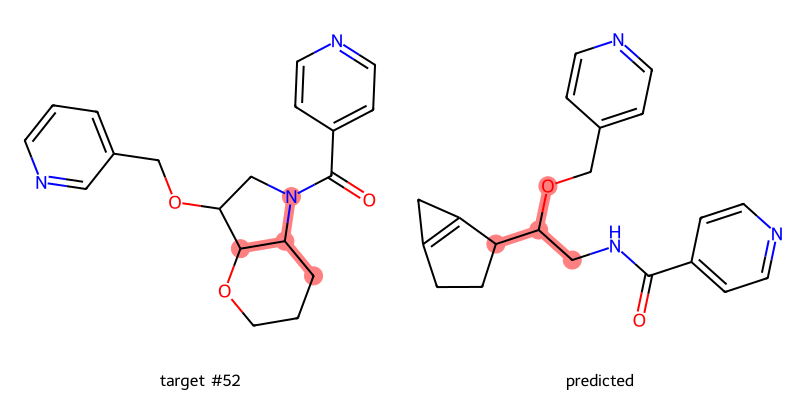

In [63]:
highlighter(52,0)